In [1]:
# todo: demonstrate the FFT version of this that we'll actually use in hardware
costable = [cos((2x+1)*u*pi/16) for x=0:7, u=0:7]

function dct2_scale(v, u)
    m = u == 0 ? 1/sqrt(2) : 1
    m *= v == 0 ? 1/sqrt(2) : 1
end

function dct2(s)
    [1/4 * dct2_scale(v,u) * 
        sum(Int8(s[y+1,x+1]*255 - 128) * costable[x+1,u+1] * costable[y+1,v+1] 
            for x=0:7, y=0:7) for v=0:7, u=0:7]
end

function idct2(S)
    [1/4 * 
        sum(dct2_scale(v, u) * S[v+1,u+1]
            * costable[x+1,u+1] * costable[y+1,v+1]
            for u=0:7, v=0:7)
    for y=0:7, x=0:7]
end

idct2 (generic function with 1 method)

In [2]:
q_table = [ 16  11  10  16  24  40  51  61;
            12  12  14  19  26  58  60  55;
            14  13  16  24  40  57  69  56;
            14  17  22  29  51  87  80  62;
            18  22  37  56  68 109 103  77;
            24  35  55  64  81 104 113  92;
            49  64  78  87 103 121 120 101;
            72  92  95  98 112 100 103  99 ]

q_factor = 4

function quantize(S)
    Int16.(round.(S ./ q_table ./ q_factor))
end

function unquantize(S)
    S .* q_table .* q_factor
end

unquantize (generic function with 1 method)

In [3]:
struct ZigZagIter
    xs
end

function Base.iterate(it :: ZigZagIter)
    (it.xs[1, 1], (1,2,:downleft))
end

function Base.iterate(it :: ZigZagIter, (i, j, s))
    if (i, j) > size(it.xs)
        return nothing
    end
    
    ii = i
    jj = j
    ss = s
    
    if s == :downleft
        if i == size(it.xs)[1]
            jj = j + 1
            ss = :upright
        elseif j == 1
            ii = i + 1
            ss = :upright
        else
            ii = i + 1
            jj = j - 1
        end
    elseif s == :upright
        if j == size(it.xs)[2]
            ii = i + 1
            ss = :downleft
        elseif i == 1
            jj = j + 1
            ss = :downleft
        else
            ii = i - 1
            jj = j + 1
        end
    end
    
    (it.xs[i, j], (ii, jj, ss))
end

function Base.length(it :: ZigZagIter)
    length(it.xs)
end

In [4]:
function runlength_encode(S)
    num = 0    
    out = []
    
    for x = Iterators.drop(ZigZagIter(S), 1)
        if x == 0
            num += 1
        else
            while num > 15
                num -= 16
                push!(out, :zrl)
            end
            push!(out, (num, x))            
            num = 0
        end
    end
    
    if num != 0
        push!(out, :eob)
    end
    
    S[1,1], out
end

runlength_encode (generic function with 1 method)

In [5]:
ac_eob = [1, 0, 1, 0]

ac_zrl = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

ac_lens = [
    2  2  3  4  5  7  8  10 16 16;
    4  5  7  9  11 16 16 16 16 16;
    5  8  10 12 16 16 16 16 16 16; 
    6  9  12 16 16 16 16 16 16 16; 
    6  10 16 16 16 16 16 16 16 16; 
    7  11 16 16 16 16 16 16 16 16; 
    7  12 16 16 16 16 16 16 16 16; 
    8  12 16 16 16 16 16 16 16 16; 
    9  15 16 16 16 16 16 16 16 16; 
    9  16 16 16 16 16 16 16 16 16; 
    9  16 16 16 16 16 16 16 16 16; 
    10 16 16 16 16 16 16 16 16 16; 
    10 16 16 16 16 16 16 16 16 16; 
    11 16 16 16 16 16 16 16 16 16; 
    16 16 16 16 16 16 16 16 16 16; 
    16 16 16 16 16 16 16 16 16 16;
]

ac_codes = [
    0x0000 0x0001 0x0004 0x000b 0x001a 0x0078 0x00f8 0x03f6 0xff82 0xff83;
    0x000c 0x001b 0x0079 0x01f6 0x07f6 0xff84 0xff85 0xff86 0xff87 0xff88;
    0x001c 0x00f9 0x03f7 0x0ff4 0xff89 0xff8a 0xff8b 0xff8c 0xff8d 0xff8e;
    0x003a 0x01f7 0x0ff5 0xff8f 0xff90 0xff91 0xff92 0xff93 0xff94 0xff95;
    0x003b 0x03f8 0xff96 0xff97 0xff98 0xff99 0xff9a 0xff9b 0xff9c 0xff9d;
    0x007a 0x07f7 0xff9e 0xff9f 0xffa0 0xffa1 0xffa2 0xffa3 0xffa4 0xffa5;
    0x007b 0x0ff6 0xffa6 0xffa7 0xffa8 0xffa9 0xffaa 0xffab 0xffac 0xffad;
    0x00fa 0x0ff7 0xffae 0xffaf 0xffb0 0xffb1 0xffb2 0xffb3 0xffb4 0xffb5;
    0x01f8 0x7fc0 0xffb6 0xffb7 0xffb8 0xffb9 0xffba 0xffbb 0xffbc 0xffbd;
    0x01f9 0xffbe 0xffbf 0xffc0 0xffc1 0xffc2 0xffc3 0xffc4 0xffc5 0xffc6;
    0x01fa 0xffc7 0xffc8 0xffc9 0xffca 0xffcb 0xffcc 0xffcd 0xffce 0xffcf;
    0x03f9 0xffd0 0xffd1 0xffd2 0xffd3 0xffd4 0xffd5 0xffd6 0xffd7 0xffd8;
    0x03fa 0xffd9 0xffda 0xffdb 0xffdc 0xffdd 0xffde 0xffdf 0xffe0 0xffe1;
    0x07f8 0xffe2 0xffe3 0xffe4 0xffe5 0xffe6 0xffe7 0xffe8 0xffe9 0xffea;
    0xffeb 0xffec 0xffed 0xffee 0xffef 0xfff0 0xfff1 0xfff2 0xfff3 0xfff4;
    0xfff5 0xfff6 0xfff7 0xfff8 0xfff9 0xfffa 0xfffb 0xfffc 0xfffd 0xfffe;
]

# column = size, row = run
ac_words = [digits(code, base=2, pad=len) |> reverse for (len, code) = zip(ac_lens, ac_codes)]

# code word for each dc difference category
dc_words = [
    [0, 0],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1, 0],
    [1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0]
]

12-element Array{Array{Int64,1},1}:
 [0, 0]
 [0, 1, 0]
 [0, 1, 1]
 [1, 0, 0]
 [1, 0, 1]
 [1, 1, 0]
 [1, 1, 1, 0]
 [1, 1, 1, 1, 0]
 [1, 1, 1, 1, 1, 0]
 [1, 1, 1, 1, 1, 1, 0]
 [1, 1, 1, 1, 1, 1, 1, 0]
 [1, 1, 1, 1, 1, 1, 1, 1, 0]

In [6]:
function ones_encode(n)
    s = 0
    if n < 0
        n = -n
        s = 1
    end
    
    BitArray(xor.(s, digits(n, base=2) |> reverse))
end

function huffman_encode(previous_dc, dc, acs, output)
    dc_diff = ones_encode(dc - previous_dc)
    append!(output, dc_words[length(dc_diff) + 1])
    append!(output, dc_diff)
    
    for symbol = acs
        if symbol == :zrl
            append!(output, ac_zrl)
        elseif symbol == :eob
            append!(output, ac_eob)
        else
            run, value = symbol
            bits = ones_encode(value)
            append!(output, ac_words[run + 1, length(bits)])
            append!(output, bits)
        end
    end
end

huffman_encode (generic function with 1 method)

In [7]:
function img_blocks(i)
    ys, xs = size(i)
    [@view i[y:y+7, x:x+7] for y=1:8:ys, x=1:8:xs]
end

function img_from_blocks(bs)
    sz = size(bs)
    r = zeros(sz .* 8)
    for j=1:sz[2]
        for i=1:sz[1]
            r[i*8-7:i*8,j*8-7:j*8] = bs[i,j]
        end
    end
    r
end

img_from_blocks (generic function with 1 method)

In [8]:
pows_2 = UInt8(2) .^ collect(7:-1:0)
function bits_to_byte(bits)
    UInt8(sum(pows_2[bits]))
end

function encode_img(img)
    blocks = img_blocks(img)
    processed_blocks = runlength_encode.(quantize.(dct2.(blocks)))
    
    out = BitArray([])
    prev_dc = 0
    for row = eachrow(processed_blocks)
        for (dc, acs) = row
            huffman_encode(prev_dc, dc, acs, out)
            prev_dc = dc
        end
    end
    
    if length(out) % 8 != 0
        append!(out, repeat([0], 8 - length(out) % 8))
    end
    
    bytes = []
    for i=1:8:length(out)
        push!(bytes, bits_to_byte(out[i:i+7]))
    end
    
    bytes
end

encode_img (generic function with 1 method)

In [9]:
function uncompressed_bytes(i)
    vec(UInt8.(i * 255))
end

uncompressed_bytes (generic function with 1 method)

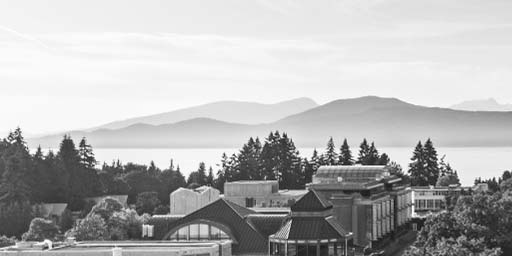

In [10]:
using Images, FileIO
orig_img = load(download("https://www.ubc.ca/_assets/img/about-ubc/about_ubc-1200x438.jpg"))
orig_img = Gray.(orig_img[33:32+256, 33:32+512])

In [11]:
uncompressed = uncompressed_bytes(orig_img)
uncompressed_size = length(uncompressed)
println("Uncompressed size: $uncompressed_size")

Uncompressed size: 131072


In [12]:
compressed = encode_img(orig_img)
compressed_size = length(compressed)
println("Compressed size: $compressed_size")

Compressed size: 5375
